In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')


In [2]:

df = pd.read_csv(r"C:\Users\elaha\Documents\Machine Learning Engineer- Task1\train.csv").dropna()


In [3]:
df.columns

Index(['Age', 'Gender', 'Marital Status', 'Number of Dependents',
       'Household Size', 'Education Level', 'Occupation',
       'Years in Current Job', 'Income Level', 'Credit Score',
       'Number of Credit Inquiries', 'Housing Status',
       'City or Region of Residence', 'Previous Bankruptcy Status',
       'Health Condition', 'Family Health History', 'Marital History',
       'Residency Stability', 'Financial Stability of Parents',
       'Average Monthly Expenses', 'Credit Card Usage', 'Savings Rate',
       'Number of Loans Taken', 'Mortgage Information', 'Investment Accounts',
       'Emergency Fund Status', 'Loan Delinquencies History',
       'Bank Account Activity', 'Tax Filing History',
       'Utility Bills Payment History', 'Number of Credit Cards Held',
       'Job Loss', 'Divorce History', 'Major Medical Emergency',
       'Adoption History', 'Bankruptcy History', 'Health-related Legal Claims',
       'Domestic or International Relocation', 'Local Unemployment Rate'

In [4]:
df.isnull().sum()

Age                                     0
Gender                                  0
Marital Status                          0
Number of Dependents                    0
Household Size                          0
Education Level                         0
Occupation                              0
Years in Current Job                    0
Income Level                            0
Credit Score                            0
Number of Credit Inquiries              0
Housing Status                          0
City or Region of Residence             0
Previous Bankruptcy Status              0
Health Condition                        0
Family Health History                   0
Marital History                         0
Residency Stability                     0
Financial Stability of Parents          0
Average Monthly Expenses                0
Credit Card Usage                       0
Savings Rate                            0
Number of Loans Taken                   0
Mortgage Information              

In [5]:

df['Expense_to_Income'] = df['Average Monthly Expenses'] / (df['Income Level'] + 1)
df['Loan_to_Income'] = df['Number of Loans Taken'] / (df['Income Level'] + 1)
df['Credit_Utilization'] = df['Credit Card Usage'] / (df['Income Level'] + 1)


In [6]:

def custom_risk(row):
    credit_score = row['Credit Score']
    dti = row['Debt-to-Income Ratio']
    savings = row['Savings Rate']
    delinq = row['Loan Delinquencies History']
    emergency_fund = row['Emergency Fund Status']
    taxes_paid = row['Tax Filing History']
    bills_paid = row['Utility Bills Payment History']
    bankruptcy = row['Previous Bankruptcy Status']
    credit_use = row['Credit Card Usage'] / (row['Income Level'] + 1)

    if (
        credit_score >= 700 and dti <= 0.3 and savings >= 0.2 and delinq == 0 and
        emergency_fund >= 10000 and taxes_paid == 1 and bills_paid == 1
    ):
        return 0  # Healthy
    elif (
        (600 <= credit_score < 700) or (0.31 <= dti <= 0.6) or delinq <= 2 or savings >= 0.1
    ):
        return 1  # Moderate Risk
    else:
        return 2  # High Risk

df['Custom Risk'] = df.apply(custom_risk, axis=1)


In [7]:
print(df['Custom Risk'].value_counts())


Custom Risk
1    97495
2     2325
0      180
Name: count, dtype: int64


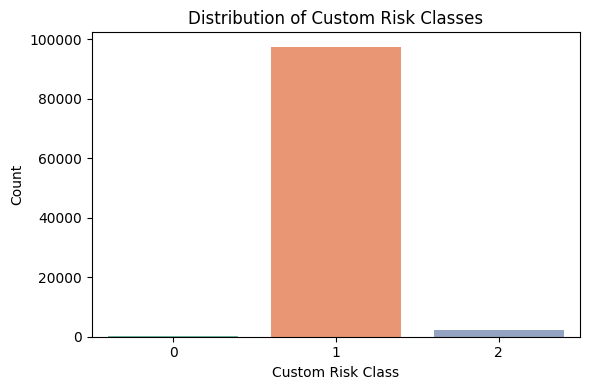

In [8]:

plt.figure(figsize=(6, 4))
sns.countplot(x=df['Custom Risk'], palette="Set2")
plt.title("Distribution of Custom Risk Classes")
plt.xlabel("Custom Risk Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [9]:

X = df.drop(["Risk Profile", "Custom Risk"], axis=1)
y = df["Custom Risk"]


In [11]:
# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE()

# Apply SMOTE for oversampling
X_resampled, y_resampled = smote.fit_resample(X, y)

In [12]:
X_resampled.shape, y_resampled.shape

((292485, 50), (292485,))

In [15]:
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Add the target variable as a new column
df_resampled['Custom Risk'] = y_resampled

In [16]:
print(df_resampled['Custom Risk'].value_counts())

Custom Risk
1    97495
2    97495
0    97495
Name: count, dtype: int64


In [17]:
df_resampled.to_csv('resampled_data.csv', index=False)


In [18]:
from IPython.display import FileLink

# Create a clickable download link
FileLink('resampled_data.csv')

C:\Users\elaha\resampled_data.csv

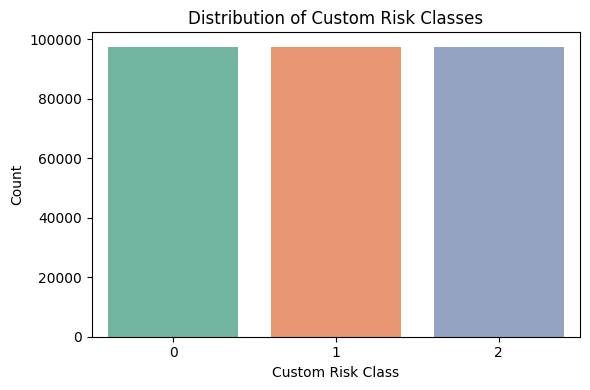

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_resampled['Custom Risk'], palette="Set2")
plt.title("Distribution of Custom Risk Classes")
plt.xlabel("Custom Risk Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [23]:

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)


In [24]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.998256320836966

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19475
           1       1.00      0.99      1.00     19466
           2       0.99      1.00      1.00     19556

    accuracy                           1.00     58497
   macro avg       1.00      1.00      1.00     58497
weighted avg       1.00      1.00      1.00     58497



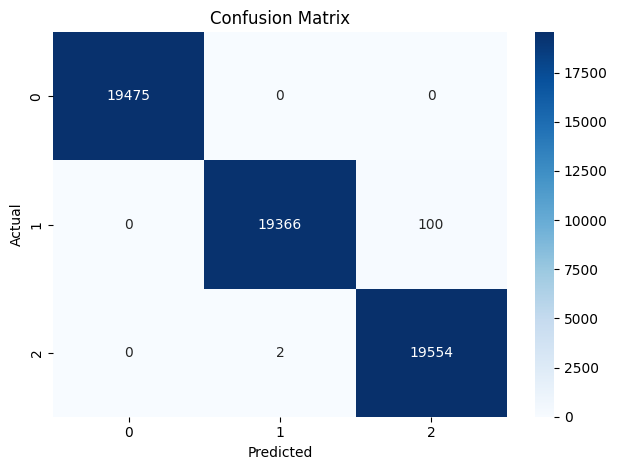

In [26]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

test_df = pd.read_csv(r"C:\Users\elaha\Documents\Machine Learning Engineer- Task1\test.csv")

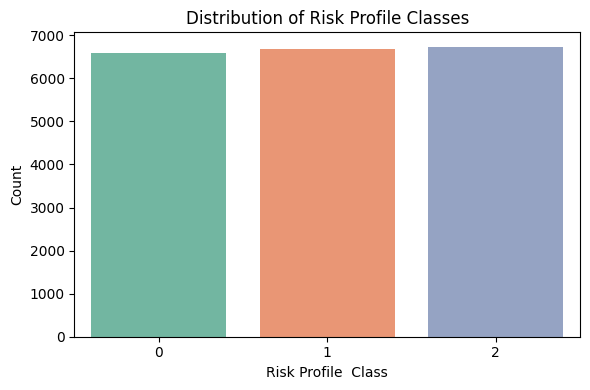

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x=test_df['Risk Profile'], palette="Set2")
plt.title("Distribution of Risk Profile Classes")
plt.xlabel("Risk Profile  Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [33]:
# Create the same features as in training
test_df['Expense_to_Income'] = test_df['Average Monthly Expenses'] / (test_df['Income Level'] + 1)
test_df['Loan_to_Income'] = test_df['Number of Loans Taken'] / (test_df['Income Level'] + 1)
test_df['Credit_Utilization'] = test_df['Credit Card Usage'] / (test_df['Income Level'] + 1)


In [35]:
# Predict custom risk class using trained model
test_preds = model.predict(X_test)


In [37]:
# Add predictions to test_df
test_df['Risk Profile'] = test_preds

# View sample results
print(test_df[['Risk Profile']].value_counts())


ValueError: Length of values (58497) does not match length of index (20000)

In [38]:
X_test_new = preprocessor.transform(test_df)


NameError: name 'preprocessor' is not defined